 # PtyRAD - PTYchographic Reconstruction with Automatic Differentiation

 Chia-Hao Lee

cl2696@cornell.edu

Created 2024.03.08

# 00. Imports

In [1]:
from data_io import load_fields_from_mat, read_matv7_3
from preprocess import preprocess_ptycho_output_dict 
from utils import complex_object_interp3d, near_field_evolution, imshift_batch
from forward import multislice_forward_model_batch_all_omode_occu
#from models import PtychoAD
#from optimization import CombinedLoss
import visualization
import optimization
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tifffile import imwrite
import torch

GPUID = 0
DEVICE = torch.device("cuda:" + str(GPUID))
print("Execution device: ", DEVICE)
print("PyTorch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)
print("CUDA device:", torch.cuda.get_device_name(GPUID))

Execution device:  cuda:0
PyTorch version:  2.1.0
CUDA available:  True
CUDA version:  12.1
CUDA device: Quadro P5000


# 01. Loading and Preprocessing

In [2]:
# Setup data path
ptycho_output_mat_path = "data/CNS_from_Hari/local_AD.mat" #"data/CNS_from_Hari/Niter10000.mat"
exp_CBED_path =          "data/CNS_from_Hari/231002_fov_23p044A_x_24p402A_thickness_9p978A_step0p28_conv30_dfm100_det70_TDS_500configs_xdirection_Co_0p25_Nb_0_S_0.mat"

print("Loading ptycho output and input CBED")
ptycho_output_dict = load_fields_from_mat(ptycho_output_mat_path, 'All', squeeze_me=True, simplify_cells=True)
input_CBED         = read_matv7_3(exp_CBED_path, 'cbed')

Loading ptycho output and input CBED
Success! .mat File path = data/CNS_from_Hari/local_AD.mat


In [3]:
# Preprocess the CBED orientation
print(f"input_CBED.shape = {input_CBED.shape}") # The .mat reads (164,164,82,87), note the 87 corresponds to the object horizontal direction (noted as N_scan_y in Hari's notation)
input_CBED_reshape = input_CBED.reshape(input_CBED.shape[0]*input_CBED.shape[1], input_CBED.shape[2], input_CBED.shape[3], order = 'C')
print(f"input_CBED.shape = {input_CBED_reshape.shape}")
input_CBED_reshape = input_CBED_reshape.transpose(0,2,1) # To swap ky into the 1st dimension

input_CBED.shape = (87, 82, 164, 164)
input_CBED.shape = (7134, 164, 164)


In [4]:
# Preprocessing and setting up the data dimension
print("Preprocessing ptycho output and experimental CBED\n")
probe, object, exp_params = preprocess_ptycho_output_dict(ptycho_output_dict)
cbeds                     = input_CBED_reshape # preprocess_CBED(exp_CBED) # (Nscan, ky, kx) that matches the .tif view

# Prepare the experimental param for forward model and dataset generation
lambd           = exp_params['lambd']
dx_spec         = exp_params['dx_spec']
z_distance      = 10 #exp_params['z_distance_arr'] # Ang, for 2D input, put the final desired total thickness if you're planning to do multislice
probe_positions = exp_params['probe_positions']
Nlayer          = exp_params['Nlayer']
N_scans         = exp_params['N_scans']

# Preprocessing variables for tBL-WSe2 with Themis
object = object[None, :,:]#object.transpose((2,0,1)) # Converting object into (Nz, Ny, Nx)
probe = probe.transpose((2,0,1))        # Converting probe into (pmode, Ny, Nx)
      
print(f"\nobject dtype/shape          (Nz, Ny, Nx) = {object.dtype}, {object.shape},\
        \nprobe data dtype/shape   (pmode, Ny, Nx) = {probe.dtype}, {probe.shape},\
        \ncbeds data dtype/shape       (N, Ky, Kx) = {cbeds.dtype}, {cbeds.shape}")

Preprocessing ptycho output and experimental CBED

Handling single slice ptycho .mat
`z_distance_arr` and `Nlayer` is populted with 1 and 1

object dtype/shape          (Nz, Ny, Nx) = complex64, (1, 391, 403),        
probe data dtype/shape   (pmode, Ny, Nx) = complex128, (2, 164, 164),        
cbeds data dtype/shape       (N, Ky, Kx) = float32, (7134, 164, 164)


In [5]:
# Preparing the object, probe, probe position, propagator in np array

# Reslice the z slices
final_z = 10 # z slices #21 for PSO
z_zoom = final_z / Nlayer
z_distance = z_distance / z_zoom # Scale the interlayer distance based on z_zoom
z_extent = final_z * z_distance
object = complex_object_interp3d(object, (z_zoom, 1, 1), z_axis = 0, use_np_or_cp = 'np') # Use cp for faster interpolation and convert it back to np with .get() as a default postprocessing
print(f"z_zoom = {z_zoom}, final_z = {final_z} slices, z_distance = {z_distance:.4f} Ang, z_extent = {z_extent:4f} Ang")

# Calculate the crop coordinates with floating points
probe_positions = probe_positions[:, [1,0]] # The first index after shifting is the row index (along vertical axis)
crop_coordinates = probe_positions + np.ceil((object.shape[-1]/2) - (probe.shape[-1]/2)) - 1 # For Matlab - Python index shift
sub_px_shift = crop_coordinates - np.round(crop_coordinates) # This shift (tH, tW) would be added to the probe to compensate the integer obj cropping
crop_indices = np.round(crop_coordinates) # This one is rounded and 

## Calculate propagator for multislice forward model
extent = dx_spec * np.array(probe.shape[-2:])
_, H, _, _ = near_field_evolution(probe.shape[-2:], z_distance, lambd, extent, use_ASM_only=True, use_np_or_cp='np')

# Specify forward model accuracy options
N_max = 7134
pmode_max = 1 # 2
omode_max = 1 # 64 # By default we only do 1 object mode

object_data = np.broadcast_to(object, (omode_max, *object.shape))
probe_data = probe[:pmode_max, :, :].astype('complex64')
crop_indices_data = crop_indices[:N_max].astype('int16')
shift_vec_data = sub_px_shift.astype('float32')
cbeds_data = 1e8 * cbeds[:N_max].astype('float32')
H = H.astype('complex64')
      
print(f"\nobject_data dtype/shape (omode, Nz, Ny, Nx) = {object_data.dtype}, {object_data.shape}, \
        \nprobe_data dtype/shape      (pmode, Ny, Nx) = {probe_data.dtype}, {probe_data.shape}, \
        \ncrop_indices_data                     (N,2) = {crop_indices_data.dtype}, {crop_indices_data.shape}, \
        \nshift_vec_data                        (N,2) = {shift_vec_data.dtype}, {shift_vec_data.shape}, \
        \ncbeds_data dtype/shape          (N, Ky, Kx) = {cbeds_data.dtype}, {cbeds_data.shape}, \
        \nH dtype/shape                      (Ky, Kx) = {H.dtype}, {H.shape}")

The object shape is interpolated to (10, 391, 403).
z_zoom = 10.0, final_z = 10 slices, z_distance = 1.0000 Ang, z_extent = 10.000000 Ang

object_data dtype/shape (omode, Nz, Ny, Nx) = complex64, (1, 10, 391, 403),         
probe_data dtype/shape      (pmode, Ny, Nx) = complex64, (1, 164, 164),         
crop_indices_data                     (N,2) = int16, (7134, 2),         
shift_vec_data                        (N,2) = float32, (7134, 2),         
cbeds_data dtype/shape          (N, Ky, Kx) = float32, (7134, 164, 164),         
H dtype/shape                      (Ky, Kx) = complex64, (164, 164)


### Note: Everything is still np array (complex) from this cell, it'll be converted to tensor later

In [6]:
class PtychoAD(torch.nn.Module):
    def __init__(self, init_obj, init_omode_occu, init_probe, init_crop_pos, init_probe_pos_shifts, H, lr_params=None, device='cuda:0'):
        super(PtychoAD, self).__init__()
        with torch.no_grad():
            self.device = device
            self.opt_obja  = torch.abs(torch.tensor(init_obj, dtype=torch.complex64, device=device))
            self.opt_objp  = torch.angle(torch.tensor(init_obj, dtype=torch.complex64, device=device))
            self.opt_probe = torch.tensor(init_probe, dtype=torch.complex64, device=device)  
            self.opt_probe_pos_shifts = torch.tensor(init_probe_pos_shifts, device=device)
            self.omode_occu = torch.tensor(init_omode_occu, dtype=torch.float32, device=device) 
            self.H = torch.tensor(H, dtype=torch.complex64, device=device)
            self.shift_probes = (lr_params['probe_pos_shifts'] != 0) # Set shift_probes to False if lr_params['probe_pos_shifts'] = 0
            
            Ny, Nx = init_probe.shape[-2:]
            ry, rx = torch.meshgrid(torch.arange(Ny, dtype=torch.int32, device=device), torch.arange(Nx, dtype=torch.int32, device=device), indexing='ij')
            self.shift_probes_grid = torch.stack([ry/Ny, rx/Nx], dim=0)
            # Create the grid for obj_ROI in a vectorized approach
            # ry is the y-grid (Ny,Nx), by adding the y coordinates from init_crop_pos (N,1) in a broadcast way, it becomes (N,Ny,Nx)
            # Stacking the modified ry and rx at the last dimension, we get obj_ROI_grid = (N,Ny,Nx,2)
            self.obj_ROI_grid = torch.stack([ry[None,:,:] + torch.tensor(init_crop_pos[:, None, None, 0], device=device), 
                                             rx[None,:,:] + torch.tensor(init_crop_pos[:, None, None, 1], device=device)], dim=-1)
                            
        # Create a dictionary to store the optimizable tensors
        self.optimizable_tensors = {
            'obja'            : self.opt_obja,
            'objp'            : self.opt_objp,
            'probe'           : self.opt_probe,
            'probe_pos_shifts': self.opt_probe_pos_shifts
        }
        # Declaring it as a ParameterDict so that I can use model.state_dict()
        # Note that when I wrap the former dict directly with ParameterDict it disables their grad_fn for unknown reason
        self.nn_params = torch.nn.ParameterDict(self.optimizable_tensors)
        
        self.optimizer_params = []
        if lr_params:
            for param_name, lr in lr_params.items():
                if param_name in self.optimizable_tensors:
                    self.optimizable_tensors[param_name].requires_grad = (lr != 0)  # Set requires_grad based on learning rate
                    if lr != 0:
                        self.optimizer_params.append({'params': [self.optimizable_tensors[param_name]], 'lr': lr})
                else:
                    print(f"Warning: '{param_name}' is not a valid parameter name.")

        print('PtychoAD major variables:')
        for name, tensor in self.optimizable_tensors.items():
            print(f"{name}: {tensor.shape}, {tensor.dtype}, device:{tensor.device}, grad:{tensor.requires_grad}, lr:{lr_params[name]:.0e}")
    
    def get_obj_ROI(self, indices):
        """ Get object ROI with integer coordinates """
        # It's strongly recommended to do integer version of get_obj_ROI
        # opt_obj.shape = (B,D,H,W,C) = (omode,D,H,W,2)
        # object_patches = (N,B,D,H,W,2), N is the additional sample index within the input batch, B is now used for omode.
        
        opt_obj = torch.stack([self.opt_obja, self.opt_objp], dim=-1)
        object_patches = opt_obj[:,:,self.obj_ROI_grid[indices,...,0],self.obj_ROI_grid[indices,...,1],:].permute(2,0,1,3,4,5)
        return object_patches
    
    def get_probes(self, indices):
        """ Get probes for each position """
        # If you're not trying to optimize probe positions, there's not much point using sub-px shifted stationary probes
        # This function will return a single probe when self.shift_probes = False,
        # and would only be returning multiple sub-px shifted probes if you're optimizing self.opt_probe_pos_shifts

        if self.shift_probes:
            probes = imshift_batch(self.opt_probe, shifts = self.opt_probe_pos_shifts[indices], grid = self.shift_probes_grid)
        else:
            probes = self.opt_probe[None,...] # Extend a singleton N dimension, essentially using same probe for all samples
        return probes
        
    def forward(self, indices):
        """ Doing the forward pass and get an output diffraction pattern for each input index """
        # The indices are passed as an array and representing the whole batch
        
        object_patches = self.get_obj_ROI(indices)
        probes = self.get_probes(indices)
        dp_fwd = multislice_forward_model_batch_all_omode_occu(object_patches, self.omode_occu, probes, self.H)
        return dp_fwd, object_patches[...,1]

# 02. Initializing optimization

In [7]:
#init_obj              = np.exp(1j * 0.05*np.random.rand(1,1,391,403)).astype('complex64')
init_obj              = np.exp(1j * 0.05*np.random.rand(*object_data.shape)).astype('complex64')
#init_obj              = object_data
#init_omode_occu       = [0.92, 0.02, 0.02, 0.02, 0.02] #np.ones(len(init_obj))/len(init_obj)
init_omode_occu       = np.ones(len(init_obj))/len(init_obj)
init_probe            = probe_data
init_crop_pos         = crop_indices_data
init_probe_pos_shifts = shift_vec_data
measurements  = torch.from_numpy(cbeds_data).to(DEVICE)

model = PtychoAD(init_obj, init_omode_occu, init_probe, init_crop_pos, init_probe_pos_shifts, H, 
                lr_params={'obja': 0,
                           'objp': 3e-4,
                           'probe': 1e-5, 
                           'probe_pos_shifts': 0},
                device=DEVICE)

optimizer = torch.optim.Adam(model.optimizer_params)

PtychoAD major variables:
obja: torch.Size([1, 10, 391, 403]), torch.float32, device:cuda:0, grad:False, lr:0e+00
objp: torch.Size([1, 10, 391, 403]), torch.float32, device:cuda:0, grad:True, lr:3e-04
probe: torch.Size([1, 164, 164]), torch.complex64, device:cuda:0, grad:True, lr:1e-05
probe_pos_shifts: torch.Size([7134, 2]), torch.float32, device:cuda:0, grad:False, lr:0e+00


In [ ]:
# # # Loading from past state_dict
# model.load_state_dict(torch.load('H:\workspace\p01_code\deep_ptycho\ptyrad\output\CNS_64obj_5e-4_random\obj_CNS_64obj_5e-4_0050.pt'))
# model.optimizer_params[0]['lr'] = 1e-5
# opt = torch.optim.Adam(model.optimizer_params)

In [ ]:
# plt.figure()
# plt.imshow(model.opt_obj[0,0,...,1].detach().cpu())
# plt.show()

## Profiler test

In [ ]:
# from torch.profiler import profile, record_function, ProfilerActivity

# indices = np.arange(256)
# # warm-up
# model(indices)

# with profile(activities=[ProfilerActivity.CUDA, ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
#     cbeds = model(indices)
# print(prof.key_averages(group_by_stack_n=10).table(sort_by='self_cpu_time_total', row_limit=10))

## Modify the MS-object

In [48]:
# Roll the last 2 z-slice and reverse the order
modified_tensor = torch.concatenate([model.opt_objp[:,-3:].flip(1), model.opt_objp[:,:-3]], dim=1)
modified_tensor.shape

torch.Size([1, 10, 391, 403])

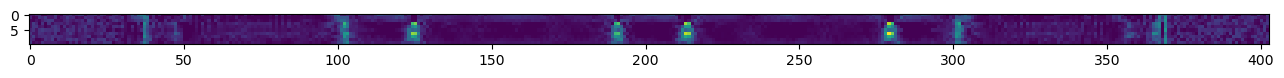

In [49]:
plt.figure(figsize=(16,5))
plt.imshow(modified_tensor[0,:,195,:].detach().cpu().numpy())
plt.show()

In [50]:
model.opt_objp.data = modified_tensor

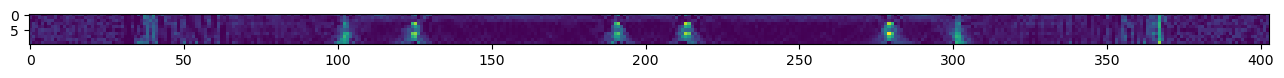

In [190]:
plt.figure(figsize=(16,5))
plt.imshow(model.opt_objp[0,:,195,:].detach().cpu().numpy())
plt.show()

In [161]:
model.optimizer_params[0]['lr'] = 6e-4
model.optimizer_params[1]['lr'] = 0

In [115]:
model.optimizer_params[0]['lr'] = 0
model.optimizer_params[1]['lr'] = 3e-4

## 02.01 Check the forward pass

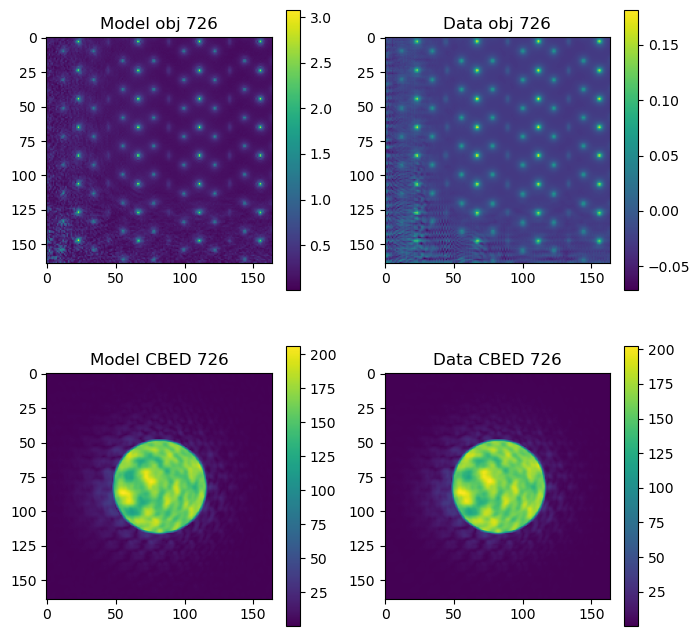

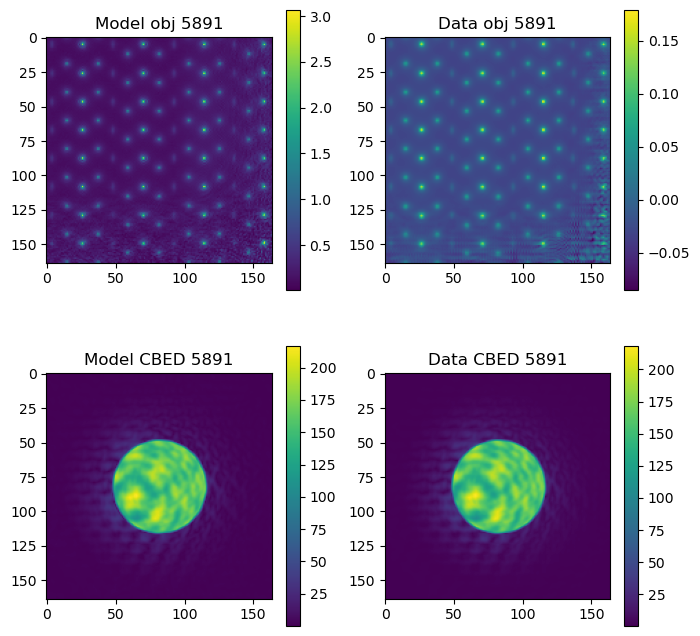

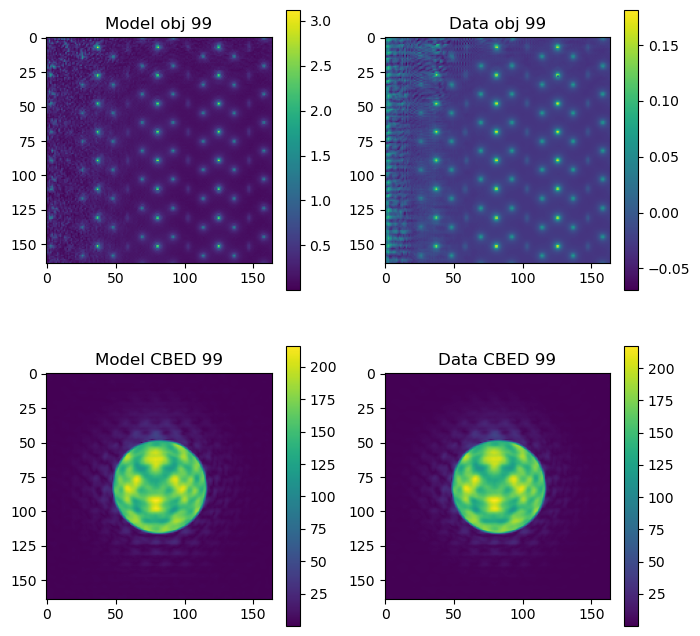

In [191]:
reload(visualization)
from visualization import plot_forward_pass

indices = np.random.randint(0,N_max,3)
dp_power = 0.5

plot_forward_pass(model, indices, dp_power, object_data, crop_indices_data, cbeds_data)

# 03. Main optimization loop

## Finetune the loss params

In [196]:
reload(optimization)
from optimization import CombinedLoss_patch

loss_params = {
    'loss_single': {'state':  True,  'weight': 1.0, 'dp_pow': 0.5},
    'loss_pacbed': {'state': False,  'weight': 1.0, 'dp_pow': 0.2},
    'loss_tv'    : {'state': False,  'weight': 1e-4},
    'loss_l1'    : {'state': False,  'weight': 1.0},
    'loss_l2'    : {'state': False,  'weight': 1.0}
}
with torch.no_grad():
    loss_fn = CombinedLoss_patch(loss_params, device=DEVICE)
    #np.random.seed(42)
    indices = np.random.randint(0,N_max,40)
    model_CBEDs, objp_patches = model(indices)
    measured_CBEDs = measurements[indices]
    loss_batch, losses = loss_fn(model_CBEDs, measured_CBEDs, objp_patches, model.omode_occu)

# Find the maximum length of loss_name
max_length = max(len(loss_name) for loss_name in loss_params.keys())

# Print loss_name and loss_value with padding
for loss_name, loss_value in zip(loss_params.keys(), losses):
    print(f"{loss_name.ljust(max_length)} : {loss_value.detach().cpu().numpy():.4f}")

loss_single : 1.4715
loss_pacbed : 0.0000
loss_tv     : 0.0000
loss_l1     : 0.0000
loss_l2     : 0.0000


In [184]:
from time import time
import os

output_path = 'output/CNS_1obj_10slice_3e-4_random_clamp/'
os.makedirs(output_path, exist_ok=True)

NITER = 10
BATCH_SIZE = 256
num_batch = len(measurements) / BATCH_SIZE # The actual batch size would only be "close" if it's not divisible by len(measurments)
cbed_shape = measurements.shape[1:]
#loss_iters = []


for iter in range(NITER+1):
    batch_losses = {name: [] for name in loss_params.keys()}
    shuffled_indices = np.random.choice(len(measurements), size=len(measurements), replace=False) # Creates a shuffled 1D array of indices
    batches = np.array_split(shuffled_indices, num_batch)                                         # return a list of `num_batch` arrays, or [batch0, batch1, ...]
    start_iter_t = time()

    for batch_idx, batch in enumerate(batches):
        start_batch_t = time()
        optimizer.zero_grad()
        model_CBEDs, objp_patches = model(batch)
        measured_CBEDs = measurements[batch]
        loss_batch, losses = loss_fn(model_CBEDs, measured_CBEDs, objp_patches, model.omode_occu)
        loss_batch.backward()
        optimizer.step()
        torch.cuda.synchronize()
        end_batch_t = time()

        for loss_name, loss_value in zip(loss_params.keys(), losses):
            batch_losses[loss_name].append(loss_value.detach().cpu().numpy())

        if batch_idx in np.linspace(0, len(batches) - 1, num=6, dtype=int):
            print(f"Done batch {batch_idx} in iter {iter} in {(end_batch_t - start_batch_t):.3f} sec")
            
    torch.cuda.synchronize()
    end_iter_t = time()

    avg_losses = {name: np.mean(values) for name, values in batch_losses.items()}
    loss_str = ', '.join([f"{name}: {value:.4f}" for name, value in avg_losses.items()])
    print(f"Iter: {iter}, Total Loss: {sum(avg_losses.values()):.4f}, {loss_str}, "
          f"in {(end_iter_t - start_iter_t) // 60} min {(end_iter_t - start_iter_t) % 60:03f} sec")

    loss_iters.append(sum(avg_losses.values()))
    
    # Do a hard positivity constraint at the end of each iter without grad
    with torch.no_grad():
        print(f"Applying hard positivity constraint to obj phase after iter {iter}")
        model.opt_objp.data.clamp_(min=0) # Doing .clamp_ is similar to passing a softplus
        #model.opt_objp.data = softplus_fn(model.opt_objp)
        
    
    # # # ## Saving
    # if iter % 50 == 0:
    #     torch.save(model.state_dict(), os.path.join(output_path, f"model_CNS_64obj_3e-4_iter{str(iter).zfill(4)}.pt"))
    #     imwrite(os.path.join(output_path, f"image_CNS_64obj_3e-4_iter{str(iter).zfill(4)}.tif"), model.opt_objp.detach().cpu().numpy()[:,0].astype('float32'))



Done batch 0 in iter 0 in 0.611 sec
Done batch 5 in iter 0 in 0.611 sec
Done batch 10 in iter 0 in 0.609 sec
Done batch 15 in iter 0 in 0.613 sec
Done batch 20 in iter 0 in 0.610 sec
Done batch 26 in iter 0 in 0.608 sec
Iter: 0, Total Loss: 1.7013, loss_single: 1.7013, loss_pacbed: 0.0000, loss_tv: 0.0000, loss_l1: 0.0000, loss_l2: 0.0000, in 0.0 min 16.496381 sec
Applying hard positivity constraint to obj phase after iter 0
Done batch 0 in iter 1 in 0.610 sec
Done batch 5 in iter 1 in 0.612 sec
Done batch 10 in iter 1 in 0.610 sec
Done batch 15 in iter 1 in 0.610 sec
Done batch 20 in iter 1 in 0.609 sec
Done batch 26 in iter 1 in 0.609 sec
Iter: 1, Total Loss: 1.7337, loss_single: 1.7337, loss_pacbed: 0.0000, loss_tv: 0.0000, loss_l1: 0.0000, loss_l2: 0.0000, in 0.0 min 16.494798 sec
Applying hard positivity constraint to obj phase after iter 1
Done batch 0 in iter 2 in 0.611 sec
Done batch 5 in iter 2 in 0.611 sec
Done batch 10 in iter 2 in 0.608 sec
Done batch 15 in iter 2 in 0.610 

In [197]:
#imwrite(os.path.join(output_path, f"image_CNS_1obj_3e-4_iter300_loss1.67_sqsqrt.tif"), model.opt_objp.detach().cpu().numpy()[0,0].astype('float32'))
imwrite(os.path.join(output_path, f"image_CNS_1obj_10slice_3e-4_iter100_clamp_roll5.tif"), model.opt_objp.detach().cpu().numpy().astype('float32'))
torch.save(model.state_dict(), os.path.join(output_path, f"model_CNS_1obj_10slice_3e-4_iter100_clamp_roll5.pt"))


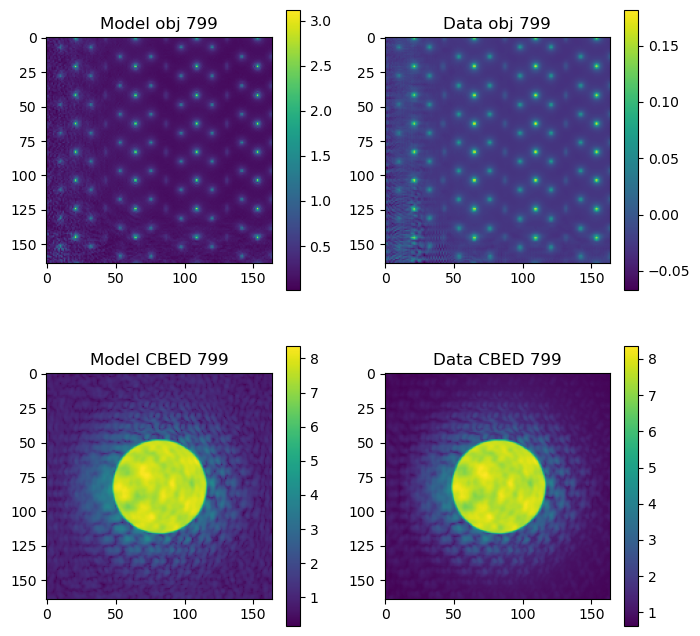

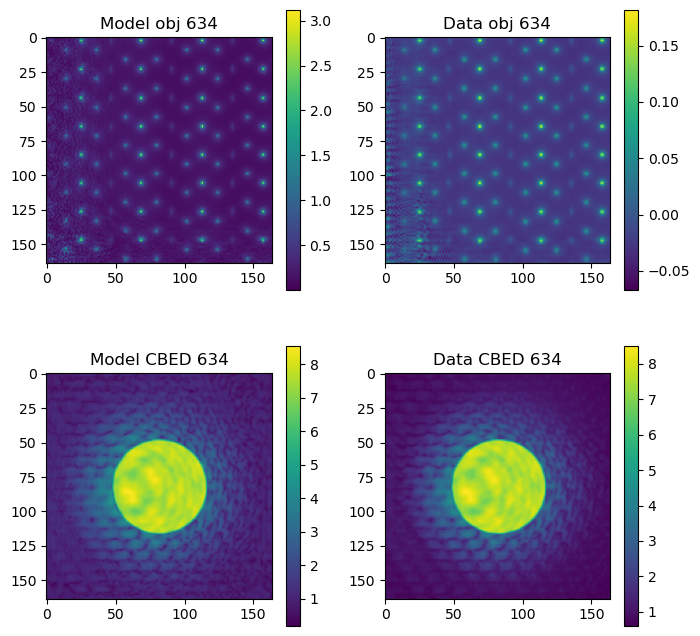

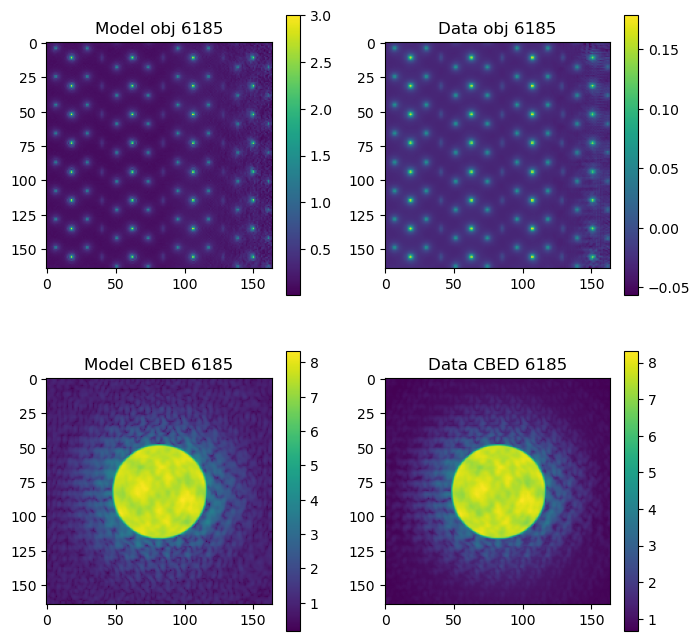

In [198]:
indices = np.random.randint(0,N_max,3)
dp_power = 0.2

plot_forward_pass(model, indices, dp_power, object_data, crop_indices_data, cbeds_data)

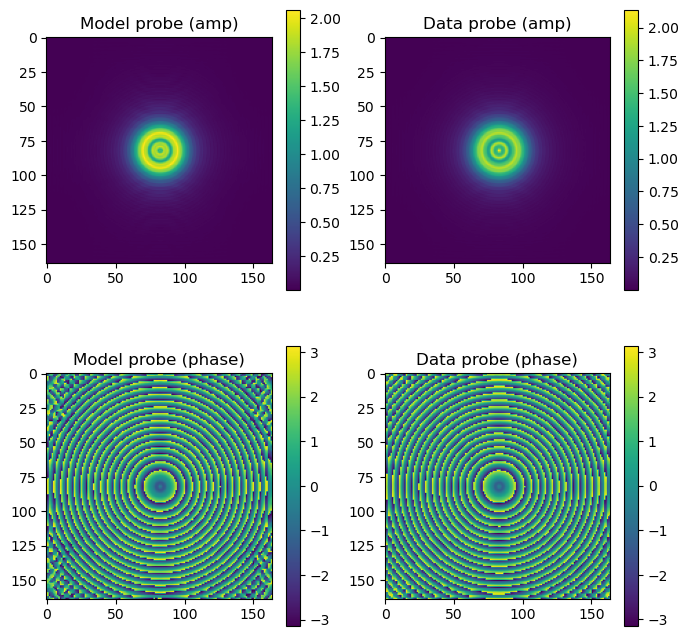

In [176]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
im00=axs[0,0].imshow(model.opt_probe[0].abs().detach().cpu())
im01=axs[0,1].imshow(np.abs(probe_data[0]))
im10=axs[1,0].imshow(model.opt_probe[0].angle().detach().cpu())
im11=axs[1,1].imshow(np.angle(probe_data[0]))

axs[0,0].set_title("Model probe (amp)")
axs[0,1].set_title("Data probe (amp)")
axs[1,0].set_title("Model probe (phase)")
axs[1,1].set_title("Data probe (phase)")


fig.colorbar(im00)
fig.colorbar(im01)
fig.colorbar(im10)
fig.colorbar(im11)

plt.show()

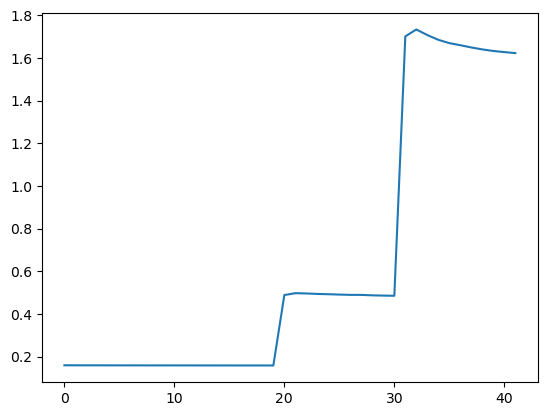

In [185]:
plt.figure()
plt.plot([x for x in loss_iters][220:])
plt.show()